# Homework 11 : Randomness and Markov Chains

## Objectives

Study random numbers, and one use:
random processes in the form of Markov Chains.

## Initialization

As always you should add initialization to the top of your notebook.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Random Number Generators

You have been warned to never write your own random number generator. For a long time it has been recognized that the generation of random numbers by computers is a necessary feature, so system libraries provided with computers have contained functions for generating them.  Unfortunately this was not considered to be very important so these functions were not carefully created.  As an example we will consider the function `randu` which, many years ago, was provided on IBM mainframes in their system library.  Who knows how many people used this for what were suppose to be real simulations!  See [Wikipedia](http://en.wikipedia.org/wiki/RANDU) for an interesting, humorous, and disturbing discussion of this random number generator.  This is but one example.  It is because of these bad implementations that many people will still never use a random number generator provided in a system library.

More recently, due to the reliance on cryptography, quality random numbers have become very important, so very good, well tested random number generators are now commonly available.  Even so, `randu` remains as **the example** of how bad random number generators can be.

The details of the algorithm are not too important for our uses but it is good to see how/why things went wrong.  The function `randu` was a *linear congruential generator*.  The random sequence is generated as 
$$ I_{j+1} = (a I_j + c) \pmod m.$$
This is a perfectly good algorithm as long as $a$, $c$, and $m$ are chosen well.  The  choices made in the library were $m=2^{31}$, $a=65539$, and $c=0$ because the calculations could be implemented very efficiently, an important criterion at that time.  This is implemented as a Python class below. You should run this cell.

In [30]:
class badrand (object) :
    """An implementation of a BAD random number generator.  This is based on
    randu() which appeared in the IBM library.  It should NEVER be used and
    will warn you to not use it!"""

    def __init__ (self, seed) :
        """Initialize the random number generator.  You MUST provide a seed.
        This will warn you about using a bad random number generator."""
        self.seed = seed
        self.m = 2**31
        self.minv = 1.0/self.m
        self.a = 65539
        self.c = 0
        print("Congratulations, you just initialized a BAD random number generator.\n"
              +"You are now ready to NOT generate good random numbers.")

    def ran (self, N) :
        """Generate N random numbers in the interval [0,1).  This will warn
        you that you have bad random numbers."""
        res = np.zeros(N)
        for j in range(N) :
            self.seed = (self.a*self.seed+self.c)%self.m
            res[j] = self.seed * self.minv
        print("Bad random numbers generated. "
              +"You are not using these for anything serious, right?")
        return res

To generate $N$ random numbers, you should use code similar to what follows. The name randu is arbitrary.  The seed must be a positive integer.  You must seed yourself. This is a bad random number generator so it is not suppose to be easy to use.  In fact, it will warn you that it is bad!
```
randu = badrand(seed)
# To get N random numbers we then use
br = randu.ran(N)
```

For our analysis we will use $N=300000$. Generate $N$ random numbers from a good random number generator, `np.random.rand` for example, and $N$ from the bad random number generator.  To see that `badrand` is not trivially bad, create a nice figure of a histogram of values generated for both sets of random numbers.  You should find that both appear nice and uniform as they should. (Note: When using `hist` you should probably plot the histograms as steps, not bars; see the `histtype='step'` option.  Also, the histograms may not appear to be flat when you make them.  If so, check the range of values on the y-axis, ....)

Congratulations, you just initialized a BAD random number generator.
You are now ready to NOT generate good random numbers.
Bad random numbers generated. You are not using these for anything serious, right?


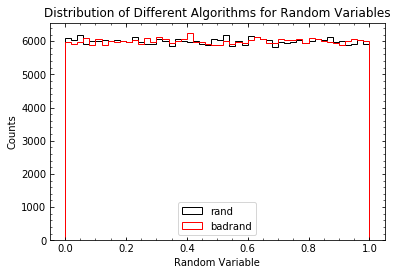

In [31]:
randu = badrand(123456) # Seed doesn't matter so just use a simple one.
N = 300000
r = np.random.rand (N) # Good random numbers
br = randu.ran (N) # Bad random numbers

# Plot the random numbers.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(r, bins=50, color='k', histtype='step', label='rand')
ax.hist(br, bins=50, color='r', histtype='step', label='badrand')
ax.set_ylim(bottom=0)
ax.legend(loc='lower center')
ax.set_xlabel('Random Variable')
ax.set_ylabel('Counts')
ax.set_title('Distribution of Different Algorithms for Random Variables');

The behavior looks perfectly sensible, so why not use this random number generator?  Let us jump to the problem: the random numbers are correlated. One easy way to see this is to perform a calculation using every 3rd random number generated. Recall that you can select every 3th element in array by specifying a step: calling `br[0::3]` will access every 3rd element beginning with the 0th one. Define $x$ to contain every third element starting with the 0th one, $y$ starting with the 1st one, and $z$ starting with the 2nd. Finally define $i = 9x-6y+z$.

Calculate $i$ for both the good and bad random numbers.  Produce a nice figure showing $i$ versus $x$ for both sets of random numbers.  Using the period marker, ‘.’, for these plots is recommended.  Plot the good random numbers first.  You should find a band that is sampled fairly evenly.  Next plot the bad random numbers.

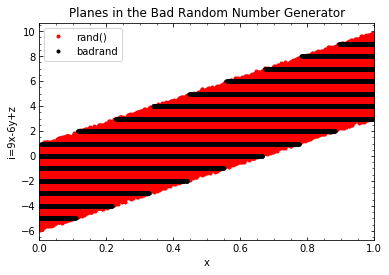

In [34]:
# Reshape the arrays and calculate the particular
# quantity that will show the problem.
# r = r.reshape((-1,3))
# br = br.reshape((-1,3))
i = 9*r[0::3] - 6*r[1::3] + r[2::3]
bi = 9*br[0::3] - 6*br[1::3] + br[2::3]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot (r[::3], i, 'r.', label='rand()')
ax.plot (br[::3], bi, 'k.', label='badrand')
ax.set_xlabel('$x$')
ax.set_ylabel('$9x-6y+z$')
ax.set_xlabel('x')
ax.set_ylabel('i=9x-6y+z')
ax.set_title('Planes in the Bad Random Number Generator')
plt.xlim(0, 1)
ax.legend (loc='best');

## Probability Density Transformations

Another useful concept involves being able to draw random numbers from complicated probability distributions. Generally, transforming one probability distribution to another is a type of [integral transformation](https://en.wikipedia.org/wiki/Probability_integral_transform). This type of transformation can appear in a number of settings, ranging from statistical analyses, to improving integration efficiency in Monte Carlo integration methods.

### A simple example

Here we will examine a simple transformation between a uniform and linear probability distribution. The uniform probability distribution on the interval $[0,1)$ is given by

$$
p_{\rm uni}(x) = \begin{cases}
1 & 0 \le x < 1  \\
0 & {\rm otherwise}
\end{cases}
$$

while the linear distribution is given by

$$
p_{\rm lin}(y) = \begin{cases}
y & 0 \le y < \sqrt{2}\\
0 & {\rm otherwise}
\end{cases}\,.
$$

The coordinate transform required to transform between these distributions is also simple, $ y = \sqrt{2x}$. Below, generate $300000$ random numbers on the interval $[0, 1)$ using `np.random.rand`. Produce a histogram as above. This time, because we are interested in evaluating this as a probability distribution, you should make sure to supply the `density='true'` option to `hist` in order to correctly normalize the distribution. Last, apply the coordinate transformation, and plot the distribution function of the transformed numbers.

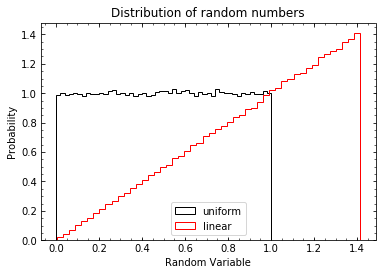

In [28]:
N=300000
runi = np.random.rand(N)
rlin = np.sqrt(2*runi)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(runi, bins=50, color='k', histtype='step', label='uniform', density='true')
ax.hist(rlin, bins=50, color='r', histtype='step', label='linear', density='true')
ax.set_ylim(bottom=0)
ax.legend(loc='lower center')
ax.set_xlabel('Random Variable')
ax.set_ylabel('Probability')
ax.set_title('Distribution of random numbers');

## Markov Chains

A Markov chain (strictly speaking the discrete time Markov chain) descibes a random process in which a system evolves by moving among a set of allowed states with given probabilities.  It has the added property that it is "memoryless"; the probability of moving from one state to another does not depend on the previous states visited.

### Where they appear

Many physical processes can be described by Markov chains.  Applications are extremely far-reaching, spanning many disciplines and areas of research.  Examples of applications of Markov chains include search engine rankings, financial market behavior, and even simulations of brain activity. See the [Wikipedia page](http://en.wikipedia.org/wiki/Markov_chain#Applications) for a list of a few more examples. Numerous extensions to the simple model of a Markov chain presented here also exist, some of which are discussed on the Wikipedia page. One extension you may have heard of are [Markov chain Monte Carlo](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) simulations, which combines Monte Carlo techniques with Markov chain techniques.

Due to the probabilistic nature of Markov chains, they frequently appear in physics in statistical and thermodynamic systems. Here we will look at a couple of examples of Markov chains in order to predict the behavior of a simple system.

### Defining the model

Markov chains model systems as a set of discrete states with some probability of transitioning from one state to another (including the possibility of remaining in the original state). At any given time there will be some probability of being in any one of the allowed states.  Let this set of probabilities be represented by a vector $\vec{q}$. As a simple example, let us consider a 3-state system, which we can write as $\vec{q} = (q_1, q_2, q_3)$. Since this is a set of probabilities and we must be in one of the states, the sum of the components of this vector must be unity. When in a given state there will be some probability of transitioning to another state: let us call $P_{i \rightarrow j}$ the probability of transitioning from state $i$ to state $j$. We can represent the transition probabilities for a 3 state system as
![Markov Chain States](https://sites.wustl.edu/mertens/files/2021/04/transition_matrix_states.png)

As an example of these ideas suppose we initially begin in state $1$ with probability $q_1^i = 1$.  This is represented by the initial state vector $\vec{q}^i = (1,0,0)$. Then the probability of transitioning to state $3$ is given by $P_{1 \rightarrow 3}$ and similarly for the other states. So after one time step the state vector will be $\vec{q}^f = (P_{1 \rightarrow 1},P_{1 \rightarrow 2},P_{2 \rightarrow 3})$. We can perform a similar calculation for the other initial states (starting in state 2 or state 3 with probability one).  The general evolution of the state vector in a Markov chain can be represented by a set of linear equations, which we can write in matrix form as
$$
\begin{pmatrix}
q_{1}^{f}\\
q_{2}^{f}\\
q_{3}^{f}
\end{pmatrix}
=
\begin{pmatrix}
P_{1\rightarrow1} & P_{2\rightarrow1} & P_{3\rightarrow1}\\
P_{1\rightarrow2} & P_{2\rightarrow2} & P_{3\rightarrow2}\\
P_{1\rightarrow3} & P_{2\rightarrow3} & P_{3\rightarrow3}
\end{pmatrix} 
\begin{pmatrix}
q_{1}\\
q_{2}\\
q_{3}
\end{pmatrix}.
$$

Analyzing the transition matrix, $\mathsf{P}$, we can find a number of special properties.  One of the intuitive properties is that each of its columns must sum to unity; this being nothing more than conservation of probability. A less obvious property is that the eigenvalues of the system will all be unity or less.  Further, if all the states of the system are accessible after some number of state changes for all possible initial states, then there will be one eigenvalue exactly equal to one. This eigenvalue and its associated eigenvector will describe the behavior of the system after a large number of state changes.

To better understand this we again let the system start in the initial state $\vec{q}^i$.  After one state change (one step in the Markov chain) the probability of being in any state will be $\mathsf{P} \vec{q}^i$. After another state change it will be $\mathsf{P}^2 \vec{q}^i$, and after $n$ changes it will be $\mathsf{P}^n \vec{q}^i$. Recall that you can raise a matrix to an arbitrary power by diagonalizing it, and raising the resulting matrix to a power. This results in the relationship 

$$ \mathsf{P}^n = \mathsf{V} \mathsf{D}^n \mathsf{V}^{-1} $$

where $\mathsf{V}$ is a matrix whose columns are the eigenvectors of $\mathsf{P}$ and $\mathsf{D}$ is a matrix containing the corresponding eigenvalues along the diagonal.

It is interesting to consider what happens in the $n \rightarrow \infty$ limit. Since one eigenvalue is unity and the rest smaller than one, taking the limit as $n \rightarrow \infty$ will result in all eigenvalues except the unitary one approaching zero.  The eigenvector corresponding to this eigenvalue is somewhat special: if the probability of being in a given state is described by this eigenvector, after subsequent steps the probability of being in a state remains the same; while the probability of being in a state described by other eigenvectors will diminish. Thus after a long time, the probability of being in a given state will be described by the eigenvector corresponding to the unit eigenvalue. This vector is sometimes referred to as the **stationary state of the system**.  After a long time, or equivalently many steps, the system will settle into its stationary state.

## Missouri Weather

As a simple model of spring weather in St. Louis, let us consider a 3-state system with the states representing a "sunny" day, a "rainy" day, and a "cloudy" day. A more realistic model may include knowledge of weather at other locations, temperatures humidity; or a full-blown climate simulation. However for a simple example we will ignore the details. Let the probabilities of transitioning from one type of weather to another be given as in the following diagram:
![Weather States](https://sites.wustl.edu/mertens/files/2021/04/weather_states.png)

Write the transition matrix $\mathsf{P}$ that describes this diagram for the state vector
$$\vec{q} = \begin{pmatrix} q_☼ \\ q_☂ \\ q_☁ \end{pmatrix}.$$
Verify that the columns of this matrix add up to one.

In [14]:
P = np.array([
        [0.05, 0.0,  0.2 ],
        [0.25, 0.3,  0.35],
        [0.7,  0.7,  0.45]
    ])

print("Sum of columns is: ", np.sum(P, axis=0))

Sum of columns is:  [1. 1. 1.]


Perform an eigenvalue decomposition of this matrix.  You should find all the eigenvalues are real (even though $\mathsf{P}$ is not symmetric) and one of them is unity.  Print the eigenvector corresponding to the unit eigenvalue.

In [15]:
(l, v) = la.eig(P)
print(f"""Eigenvalues:
{l}
Eigenvectors (in columns):
{v}
Eigenvector with eigenvalue 1:
{v[:,0]}""")

Eigenvalues:
[ 1.  +0.j  0.05+0.j -0.25+0.j]
Eigenvectors (in columns):
[[-1.79526835e-01 -7.07106781e-01 -5.34522484e-01]
 [-4.90492961e-01  7.07106781e-01 -2.67261242e-01]
 [-8.52752468e-01  2.18388044e-17  8.01783726e-01]]
Eigenvector with eigenvalue 1:
[-0.17952684 -0.49049296 -0.85275247]


This is good, but this vector looks wrong.  It is suppose to represent probabilities and the sum must be one.  It may also be the case that all the values are negative, so how could they be probabilities!  The case of negative values can easily be fixed by multiplying the vector by negative one.  (Recall why we are allowed to do this!)  The other issue is due to how eigenvectors are normalized.  (Again recall how this is done!)  Since we have a physical meaning for the vector and its normalization we will need to renormalize it.  (For different reasons and in a different manner we needed to renormalize the eigenvectors when we solved the Schrödinger equation.)

Renormalize the eigenvector from the previous part so that its sum is one.  Print the renormalized vector.  (All the probabilities better be positive now!)

In [16]:
ev = v[:,0]/np.sum(v[:,0])
print("Renormalized eigenvector is: ", ev)
print("Sum of its elements is: ", ev.sum())

Renormalized eigenvector is:  [0.11789474 0.32210526 0.56      ]
Sum of its elements is:  1.0


We can use our simple model to forecast the weather.  Given an initial state representing the weather today we can predict the probabilities of it being sunny, rainy, or cloudy after 1 day, 2 days, or 1 week.  To begin pick an initial state vector representing the weather today
$$ \vec{q}^i = \left( \begin{array}{c} q_☼ \\ q_☂ \\ q_☁ \end{array} \right). $$
Pick one that is somewhat representative of the weather where you are now!

In order to calculate the weather after one, two, and seven days you will need to calculate $\mathsf{P} \vec{q}^i$, $\mathsf{P}^2 \vec{q}^i$, and $\mathsf{P}^7 \vec{q}^i$. There are multiple ways to raise a matrix to a power. One way is to use the eigenvalue decomposition from above. As an alternative, NumPy provides a function for doing this: `np.linalg.matrix_power`.  Either of these methods is better than repeatedly multiplying the matrix with itself.

Print the probabilities for the state of the weather after 1, 2, and 7 days.  Note that after 7 days the result should look very much like the stationary state we found above.  For fun you may want to compare your predictions to those from a professional weather service and/or keep track of you predictions and see how they turn out.

In [29]:
# Here we are optimistic and start with a sunny day.
qi = np.array([1,0,0])

print(np.dot(np.linalg.matrix_power(P, 1), qi))
print(np.dot(np.linalg.matrix_power(P, 2), qi))
print(np.dot(np.linalg.matrix_power(P, 7), qi))

[0.05 0.25 0.7 ]
[0.1425 0.3325 0.525 ]
[0.11787195 0.32209387 0.56003418]


## Drunkard's Walk

A random walk is another simple example of a Markov chain.  Here we will work through a variant of the random walk where we add the special property that it is possible to get stuck in certain states. This is called an "**absorbing chain**" with the transition probabilities given in the diagram below.
![Example of an absorbing chain](https://sites.wustl.edu/mertens/files/2021/04/absorbing_chain-1024x232.png)

We can consider this to represent the path taken by an inebriated individual as he attempts to locate either his home or another bar. In state 1 the drunkard reaches home and will remain there.  In state 5 he reaches another bar and again remains there.  In between the two destinations he will stumble in either direction with probability $1/2$ (this equal probability step is the usual random walk behavior).

Systems like this are special in that more than one eigenvalue is unity so there are multiple stationary states. (The assertion made above that all states should be accessible has been broken.)

Construct the transition matrix, $\mathsf{P}$, for this system.   Print the vectors representing the stationary states of the system. 

In [6]:
### BEGIN SOLUTION
P = np.array([
        [1.0, 0.5, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.5, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.5, 0.0],
        [0.0, 0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.5, 1.0]
    ])
(l, v) = la.eig(P)
print(f"""Eigenvalues are:
{l}
Stationary states are:
{v[:,0]}
{v[:,1]}""")
### END SOLUTION

Eigenvalues are:
[ 1.        +0.j  1.        +0.j  0.70710678+0.j -0.70710678+0.j
  0.        +0.j]
Stationary states are:
[1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]


The states should correspond to the drunkard arriving at home or at the bar (states 1 and 5). If the drunk starts at home or the bar, no other states are accessible, as he will remain in those locations.

There are many other interesting questions that could be asked.  For example, suppose the drunkard starts in state labeled 2 in the figure, what is the probability he will end up at home?  Similarly, what are the probabilities when starting the in the states labeled 3 or 4?  For each of these initial states we could also determine the average number of steps taken by the drunkard.  Numerically these can be easily modeled using Monte Carlo techniques to simulate a drunkard walking from each initial state.  We will not do so here, but feel free to 
explore it on your own.